### Targeting with Evaluation

**Notation**  
- $Y_i(0)$: Potential outcome if individual $i$ is not treated.  
- $Y_i(1)$: Potential outcome if individual $i$ is treated.  
- $W_i \in \{0,1\}$: Actual treatment indicator in the randomized data.  
- $m$: Profit multiplier for outcomes.  
- $c$: Cost of treatment.  
- $e(x_i) \in (0,1)$: Propensity score (probability of treatment given features $X_i=x$).  
- $d(x)$: Proposed targeting policy (1 if treated, 0 otherwise).  

---

When designing a targeting policy, we often have two separate randomized datasets:  
1. A **training** dataset for estimating the parameters or functional form of the treatment effect.  
2. A **testing** (or evaluation) dataset with a (possibly different) randomization scheme to **off-policy** evaluate any proposed policy using inverse probability weighting.

For each individual $i$, there are two potential outcomes:

$$
Y_i(0) \quad \text{and} \quad Y_i(1).
$$

We define a profit function that scales the outcome by $m$ and subtracts a cost $c$ when treated:

$$
\pi_i(W_i) =
\begin{cases}
m \cdot Y_i(0), & \text{if } W_i=0, \\[6pt]
m \cdot Y_i(1) - c, & \text{if } W_i=1.
\end{cases}
$$

---

#### CATE and Profit Maximization

The **Conditional Average Treatment Effect** (CATE) for features $X_i=x$ is

$$
\text{CATE}(x) = E\!\bigl[\,Y_i(1) - Y_i(0)\,\bigl|\bigr.\,X_i=x\bigr].
$$

We estimate $\widehat{\text{CATE}}(x)$ from the **training** dataset. Given profit parameters $(m,c)$, a **profit-maximizing** decision rule is:

$$
d_i(x) =
\begin{cases}
1, & \text{if } m \cdot \widehat{\text{CATE}}(x) > c, \\[4pt]
0, & \text{otherwise}.
\end{cases}
$$

- A **constant-only** model might yield a single $\widehat{\text{CATE}}$ estimate and thus treat everyone if $\widehat{\text{CATE}} > \tfrac{c}{m}$.  
- A **linear** or **polynomial** model can produce more complex thresholding rules based on $x$.  

---

#### Inverse Probability Weighting (IPW)

To **evaluate** any targeting policy $d$ on the **testing** dataset, we rely on inverse probability weighting. Suppose in the testing data each individual $i$ was treated with probability $e(x_i)\in(0,1)$. The **IPW profit estimator** is:

$$
\hat{\Pi}(d) = \frac{1}{N} \sum_{i=1}^N 
\biggl[
\frac{W_i\, d(x_i)}{e(x_i)} \,\bigl(m \,Y_i(1) - c\bigr)
\;+\;
\frac{\bigl(1 - W_i\bigr)\,\bigl[1 - d(x_i)\bigr]}{1 - e(x_i)} \,\bigl(m\,Y_i(0)\bigr)
\biggr].
$$

This formula adjusts each observation by the inverse of the probability of appearing under the **realized** and **proposed** treatment statuses. Under full randomization (with $0 < e(x_i) < 1$), $\hat{\Pi}(d)$ is **unbiased** for the profit that policy $d$ would generate if fully implemented.

### Example

Below, we walk through a *concrete* illustration of the ideas. We have two datasets—*training* (with a 30% treatment probability) and *test* (with a 50% treatment probability). We assume a profit function with parameters \(m=1\) and \(c=1\). Our goal is to learn a \(\text{CATE}\) model from the training data, use it to define a profit-maximizing policy, then evaluate it on the test data via inverse probability weighting \(\text{(IPW)}\).

1. **Data-Generating Process (DGP)**  
   - We simulate a feature \(X \sim \mathcal{N}(0,1)\).  
   - We specify a true quadratic CATE:
   $$
     \text{TrueCATE}(x) = a + b\,x + c\,x^2.
   $$
   - In each dataset, each individual is randomly assigned to treatment \(W=1\) with probability \(\text{prob}\), receiving potential outcomes
   $$
     Y_i(0) = b_0 + \varepsilon_i,\quad
     Y_i(1) = b_0 + \text{TrueCATE}(x_i) + \varepsilon_i.
   $$

2. **Model Estimation on Training Data**  
   - We fit three regression models to estimate \(\text{CATE}\):
     1. *Constant-only:* \(Y \sim W\).  
     2. *Linear:* \(Y \sim W + W \times X\).  
     3. *Polynomial:* \(Y \sim W + W \times X + W \times X^2\).  
   - From each fitted model, we calculate predicted CATE for each observation by predicting \(\hat{Y}(W=1)\) minus \(\hat{Y}(W=0)\).

3. **Profit-Maximizing Policy**  
   - Given \(m=1\) and \(c=1\), a policy treats individual \(i\) if \(\widehat{\text{CATE}}(x_i) > 1\).  
   - In the *constant-only* model, if the single estimated effect exceeds 1, we treat everyone; otherwise, no one.  
   - In the *linear* or *polynomial* model, we treat only those whose predicted treatment effect is above 1.

4. **IPW Evaluation on Test Data**  
   - The test set is randomized at 50%, meaning \(e(x)=0.5\) for all \(x\).  
   - We apply each policy to the test dataset and compute
   $$
     \hat{\Pi}(d)
     = \frac{1}{N} \sum_{i=1}^N \Bigl[
       \frac{W_i\,d(x_i)}{0.5}\,\bigl(Y_i(1) - 1\bigr)
       + \frac{\bigl(1 - W_i\bigr)\,\bigl[1 - d(x_i)\bigr]}{0.5}\,\bigl(Y_i(0)\bigr)
     \Bigr].
   $$
   - This yields an off-policy estimate of each policy’s expected profit under the code’s specified profit function.

== 1) DATA GENERATING PROCESS & DATASETS ==
DGP: Y(0)=b0+eps, Y(1)=b0+(a+bX+cX^2)+eps
b0=5.0, a=1.0, b=2.0, c=-1.0, sigma=1.0,
Observational vs. Test W-probs => 0.3 & 0.5 respectively.
Profit param => m=1.0, c=1.0

Train Data (top 5 rows):
          X  W        Y0        Y1        TE         Y
0 -1.085631  1  3.225776  0.875921 -2.349855  0.875921
1  0.997345  0  3.798623  5.798616  1.999993  3.798623
2  0.282978  0  6.096257  7.582137  1.485880  6.096257
3 -1.506295  0  5.861037  1.579524 -4.281513  5.861037
4 -0.578600  0  3.479633  2.987654 -0.491979  3.479633

Test Data (top 5 rows):
          X  W        Y0        Y1        TE         Y
0  0.127158  1  3.677946  4.916093  1.238147  4.916093
1  1.401891  0  4.313787  6.152271  1.838484  4.313787
2  0.314815  0  5.186224  6.716746  1.530521  5.186224
3 -0.858449  1  5.333270  3.879437 -1.453833  3.879437
4 -0.266134  1  4.280230  4.677133  0.396904  4.677133

== 2) CAUSAL MODEL ESTIMATION & CATE FROM TRAIN ==

Constant-Only Model Pa

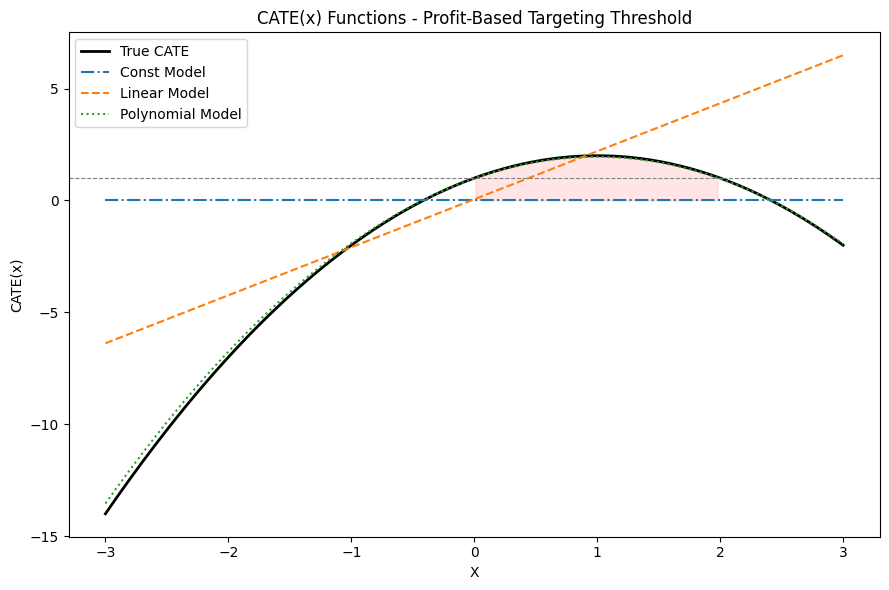

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from tabulate import tabulate

# ------------------------------------------------
# Helper Functions for DGP & Estimation
# ------------------------------------------------
def generate_data(n, b0, a, b, c, prob, sigma=1.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X = np.random.normal(0, 1, n)
    eps = np.random.normal(0, sigma, n)
    TE = a + b*X + c*(X**2)      # True CATE
    Y0 = b0 + eps
    Y1 = b0 + TE + eps
    W  = np.random.binomial(1, prob, size=n)
    Y  = W*Y1 + (1-W)*Y0
    return pd.DataFrame({'X': X, 'W': W, 'Y0': Y0, 'Y1': Y1, 'TE': TE, 'Y': Y})

def fit_constant_model(df):
    # Y ~ W (no X) => a single constant effect of W
    return smf.ols('Y ~ W', data=df).fit()

def fit_linear_model(df):
    # Y ~ W + W*X => linear in X
    return smf.ols('Y ~ W + I(W*X)', data=df).fit()

def fit_polynomial_model(df):
    # Y ~ W + W*X + W*X^2 => polynomial in X
    return smf.ols('Y ~ W + I(W*X) + I(W*X*X)', data=df).fit()

def get_predicted_TE(df, model):
    df0 = df.copy(); df0['W'] = 0
    df1 = df.copy(); df1['W'] = 1
    return model.predict(df1) - model.predict(df0)

# ------------------------------------------------
# Inverse Probability Weighting for Off-Policy Eval
# ------------------------------------------------
def evaluate_policy_ipw(df, dfunc, efunc, m=1.0, c=1.0):
    """
    IPW formula for expected profit:
    (1/N) * Σ_i [ (W_i*d_i / e_i)*(m*Y1_i - c) + ((1-W_i)*(1-d_i)/(1-e_i))*(m*Y0_i) ]
    """
    dvals = dfunc(df['X'].values)
    evals = efunc(df['X'].values)
    pi0 = m*df['Y0']
    pi1 = m*df['Y1'] - c
    w   = df['W']
    numer = ( w*dvals/evals ) * pi1 + ((1-w)*(1-dvals)/(1-evals)) * pi0
    return numer.mean()

def main():
    # -----------------------
    # STEP 1) DGP & DATA
    # -----------------------
    print("== 1) DATA GENERATING PROCESS & DATASETS ==")
    b0, a, b_, c_ = 5.0, 1.0, 2.0, -1.0   # DGP
    sigma, N = 1.0, 2000
    df_train = generate_data(N, b0, a, b_, c_, prob=0.3, sigma=sigma, seed=123)
    df_test  = generate_data(N, b0, a, b_, c_, prob=0.5, sigma=sigma, seed=999)
    
    # Suppose the profit function has parameters m=1, c=1
    m_val, c_val = 1.0, 1.0

    print(f"DGP: Y(0)=b0+eps, Y(1)=b0+(a+bX+cX^2)+eps\n"
          f"b0={b0}, a={a}, b={b_}, c={c_}, sigma={sigma},\n"
          f"Observational vs. Test W-probs => 0.3 & 0.5 respectively.\n"
          f"Profit param => m={m_val}, c={c_val}\n")

    print("Train Data (top 5 rows):")
    print(df_train.head())
    print("\nTest Data (top 5 rows):")
    print(df_test.head())

    # -----------------------
    # STEP 2) CAUSAL MODEL ESTIMATION
    # -----------------------
    print("\n== 2) CAUSAL MODEL ESTIMATION & CATE FROM TRAIN ==")
    m_const = fit_constant_model(df_train)
    m_lin   = fit_linear_model(df_train)
    m_poly  = fit_polynomial_model(df_train)

    print("\nConstant-Only Model Param Estimates:")
    print(tabulate(m_const.params.items(), headers=["Param","Value"], floatfmt=".4f"))
    print("\nLinear Model Param Estimates:")
    print(tabulate(m_lin.params.items(), headers=["Param","Value"], floatfmt=".4f"))
    print("\nPolynomial Model Param Estimates:")
    print(tabulate(m_poly.params.items(), headers=["Param","Value"], floatfmt=".4f"))

    df_train['TE_hat_const'] = get_predicted_TE(df_train, m_const)
    df_train['TE_hat_lin']   = get_predicted_TE(df_train, m_lin)
    df_train['TE_hat_poly']  = get_predicted_TE(df_train, m_poly)

    print("\nTrain Data with Estimated CATE (top 5 rows):")
    print(df_train[['X','TE','TE_hat_const','TE_hat_lin','TE_hat_poly']].head())

    # -----------------------
    # STEP 3) MODEL EVALUATION ON TEST
    # -----------------------
    print("\n== 3) MODEL EVALUATION ON TEST DATA (OFF-POLICY) ==")
    df_test['TE_hat_const'] = get_predicted_TE(df_test, m_const)
    df_test['TE_hat_lin']   = get_predicted_TE(df_test, m_lin)
    df_test['TE_hat_poly']  = get_predicted_TE(df_test, m_poly)

    # We define the policy rule: treat if m * CATE(x) > c
    # => treat if CATE(x) > c/m
    # For c=1, m=1 => treat if CATE(x) > 1.0

    threshold = c_val / m_val  # c/m
    print(f"Profit-based targeting threshold => {threshold:.3f}\n")

    def d_const(x):
        # If model's predicted CATE is constant => TE_const
        # TE_const(·) might be e.g. +some_value
        # We'll compute it for each x from the trained model
        # Then treat if TE>threshold
        te_ = m_const.params['W']  # The effect of W
        return (te_ > threshold).astype(int) * np.ones(len(x), dtype=int)

    def d_lin(x):
        # TE_lin(x) = bW + bWX*x
        bW   = m_lin.params['W']
        bWX  = m_lin.params['I(W * X)']
        te_x = bW + bWX*x
        return (te_x > threshold).astype(int)

    def d_poly(x):
        # TE_poly(x) = bW + bWX*x + bWX2*x^2
        bW     = m_poly.params['W']
        bWX    = m_poly.params['I(W * X)']
        bWX2   = m_poly.params['I(W * X * X)']
        te_x   = bW + bWX*x + bWX2*(x**2)
        return (te_x > threshold).astype(int)

    # We assume e(x)=0.5 in test => W ~ Bernoulli(0.5)
    def e_const50(x):
        return np.full_like(x, 0.5)

    ipw_const = evaluate_policy_ipw(df_test, d_const, e_const50, m=m_val, c=c_val)
    ipw_lin   = evaluate_policy_ipw(df_test, d_lin,   e_const50, m=m_val, c=c_val)
    ipw_poly  = evaluate_policy_ipw(df_test, d_poly,  e_const50, m=m_val, c=c_val)

    results = [
        ["Policy d_const (Constant Model)", ipw_const],
        ["Policy d_lin (Linear Model)",     ipw_lin],
        ["Policy d_poly (Polynomial Model)",ipw_poly]
    ]
    print("IPW formula used:\n"
          "  (1/N) * Σ_i [ (W_i*d_i / e(x_i)) * (m*Y1_i - c) "
          " + ((1 - W_i)*(1 - d_i)/(1 - e(x_i))) * (m*Y0_i) ]\n")
    print("Off-Policy IPW Estimated Profit:")
    print(tabulate(results, headers=["Policy","IPW Profit"], floatfmt=".3f"))

    # Show final decisions in test
    df_test['d_const'] = d_const(df_test['X'].values)
    df_test['d_lin']   = d_lin(df_test['X'].values)
    df_test['d_poly']  = d_poly(df_test['X'].values)

    print("\nTest Data with Scored CATE & Decisions (top 5 rows):")
    print(df_test[['X','TE','TE_hat_const','TE_hat_lin','TE_hat_poly',
                   'd_const','d_lin','d_poly']].head())

    # Plot
    x_grid = np.linspace(-3, 3, 300)
    te_true = a + b_*x_grid + c_*(x_grid**2)
    te_const = m_const.params['W'] * np.ones_like(x_grid)
    te_lin   = m_lin.params['W'] + m_lin.params['I(W * X)']*x_grid
    bW   = m_poly.params['W']
    bWX  = m_poly.params['I(W * X)']
    bWX2 = m_poly.params['I(W * X * X)']
    te_poly = bW + bWX*x_grid + bWX2*(x_grid**2)

    plt.figure(figsize=(9,6))
    plt.plot(x_grid, te_true,  label="True CATE",  c='k', lw=2)
    plt.plot(x_grid, te_const, label="Const Model", ls='-.')
    plt.plot(x_grid, te_lin,   label="Linear Model",ls='--')
    plt.plot(x_grid, te_poly,  label="Polynomial Model", ls=':')

    # highlight region > threshold in poly
    above_poly = te_poly > threshold
    plt.fill_between(x_grid, te_poly, where=above_poly, color='red', alpha=0.1)

    plt.axhline(y=threshold, color='gray', lw=0.8, linestyle='--')
    plt.title("CATE(x) Functions - Profit-Based Targeting Threshold")
    plt.xlabel("X")
    plt.ylabel("CATE(x)")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


### Qini Curves

We extend our existing setup to evaluate **multiple partial treatment policies** at different budget levels (or treatment fractions) and compare their effectiveness using a Qini-like curve. Our data-generating process (DGP) stays the same, as does our model training. However, instead of picking a **single** threshold-based policy (e.g., “treat if \(\widehat{\tau}(x) > 1\)”), we vary **what fraction** of individuals we treat, from 0% up to 100%. At each fraction, we measure the **Inverse Propensity Weighted (IPW)** profit. Plotting the resulting profit against the fraction treated gives us a **Qini-style** curve.

1. **Data Generation & CATE Estimation**  
   - We use the same DGP, generating:
     \[
       Y_i(0) = b_0 + \varepsilon_i, 
       \quad
       Y_i(1) = b_0 + (a + b\,X_i + c\,X_i^2) + \varepsilon_i,
     \]
     under randomized treatment with probabilities 0.3 (train) and 0.5 (test).  
   - We then fit **constant**, **linear**, and **polynomial** regressions to estimate \(\widehat{\tau}(x)\).

2. **Ranking Policies & Random Policy**  
   - **Random**: We shuffle the test-set indices and treat a fraction \(f\) of them at random, ignoring the \(\widehat{\tau}\) predictions.  
   - **Ranked (Linear)**: We sort individuals by \(\widehat{\tau}_{\text{lin}}(x)\) from highest to lowest. Then, for a fraction \(f\), we treat the top \(\lfloor f \cdot N\rfloor\) individuals.  
   - **Ranked (Polynomial)**: Similarly, we sort by \(\widehat{\tau}_{\text{poly}}(x)\) and treat the top fraction.

3. **Building the Qini Curve**  
   - For each fraction \(f\in\{0\%,5\%,\dots,100\%\}\):
     1. Construct a **policy** that treats exactly \(f\%\) of the test set (either random or top-\(f\%\) in the predicted ranking).  
     2. Use the **IPW** formula to compute the policy’s **estimated profit**:
       $$
         \hat{\Pi}(d) 
         \;=\; 
         \frac{1}{N}
         \sum_{i=1}^N
         \Bigl[
           \frac{W_i\,d_i}{e(x_i)}(m\,Y_i(1) - c)
           \;+\;
           \frac{(1-W_i)\,[1 - d_i]}{1 - e(x_i)}(m\,Y_i(0))
         \Bigr].
       $$
   - Collect these **(fraction, profit)** points to form a **Qini** (or cost) curve.

4. **Comparing Policies**  
   - We **plot** the profit vs. fraction-treated lines for **three** policies:
     1. Random.  
     2. Rank by \(\widehat{\tau}_{\text{lin}}(x)\).  
     3. Rank by \(\widehat{\tau}_{\text{poly}}(x)\).  
   - If the line for a model-based policy is **above** the random line, it indicates that policy can achieve **higher profit** at each budget level by focusing on individuals with the highest predicted gains.

5. **Interpretation**  
   - A steep initial slope means the policy quickly captures the **highest** value individuals at low budget fractions. If the **polynomial** policy’s curve grows faster or stays above others, that means it identifies truly high-value individuals better than the linear or random approach.
   - By seeing where curves **plateau**, we learn if there’s a diminishing return: if only a small subset has strongly positive gains, you stop seeing improvement after targeting that subset.

In essence, **Qini-style curves** transform the single threshold-based policy logic into a **continuous** set of partial policies, revealing how each model fares **across** different treatment intensities.

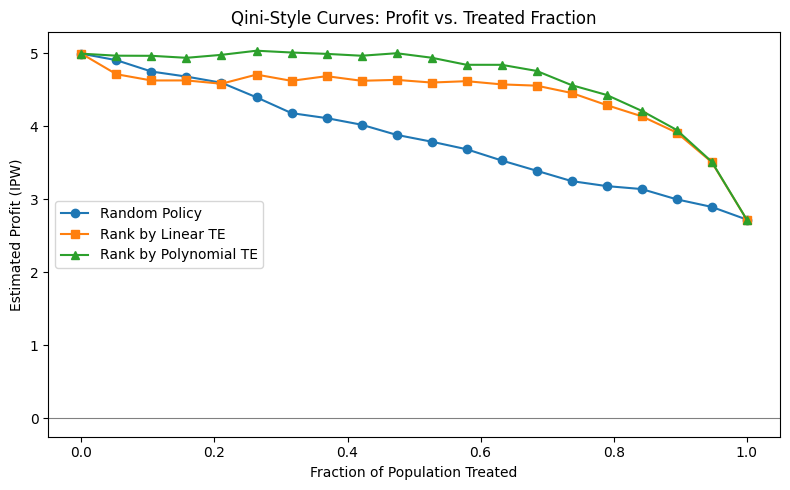

In [3]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from tabulate import tabulate

def generate_data(n, b0, a, b, c, prob, sigma=1.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X = np.random.normal(0, 1, n)
    eps = np.random.normal(0, sigma, n)
    TE = a + b*X + c*(X**2)      
    Y0 = b0 + eps
    Y1 = b0 + TE + eps
    W  = np.random.binomial(1, prob, size=n)
    Y  = np.where(W == 1, Y1, Y0)
    return pd.DataFrame({'X': X, 'W': W, 'Y0': Y0, 'Y1': Y1, 'TE': TE, 'Y': Y})

def fit_constant_model(df):
    return smf.ols('Y ~ W', data=df).fit()

def fit_linear_model(df):
    return smf.ols('Y ~ W + I(W*X)', data=df).fit()

def fit_polynomial_model(df):
    return smf.ols('Y ~ W + I(W*X) + I(W*X*X)', data=df).fit()

def get_predicted_TE(df, model):
    df0 = df.copy(); df0['W'] = 0
    df1 = df.copy(); df1['W'] = 1
    return model.predict(df1) - model.predict(df0)

def ipw_profit(df, policy, efunc, m=1.0, c=1.0):
    """
    Evaluate the policy using IPW. 
    policy: array of 0/1 decisions of length len(df).
    efunc: function returning array of e(x_i).
    """
    dvals = policy
    evals = efunc(df['X'].values)
    pi0 = m*df['Y0']
    pi1 = m*df['Y1'] - c
    w   = df['W']
    numer = ( w*dvals/evals ) * pi1 + ((1-w)*(1-dvals)/(1-evals)) * pi0
    return numer.mean()

def build_qini_curve(df, tehat, efunc, m=1.0, c=1.0, num_points=20, random_policy=False):
    """
    Build a Qini-style curve by evaluating partial treatment rules.
    If random_policy=True, we ignore tehat and just treat random subsets.
    Otherwise we sort by tehat descending and treat top fraction.
    """
    n = len(df)
    fractions = np.linspace(0, 1, num_points)  # fractions of population to treat
    qini_values = []
    
    # For each fraction f, define a policy that treats f of the population
    # - either randomly or by top TE. Then compute IPW profit.
    if random_policy:
        # We'll do a single random ordering once, to keep it consistent for all fractions
        # but in practice, you could replicate for each fraction. 
        rng = np.random.default_rng(999)  # fixed seed
        shuffle_idx = rng.permutation(n)
        # We'll treat the first f*n individuals in shuffle_idx
        for frac in fractions:
            cutoff = int(frac*n)
            policy_arr = np.zeros(n, dtype=int)
            # treat up to cutoff
            policy_arr[shuffle_idx[:cutoff]] = 1
            val = ipw_profit(df, policy_arr, efunc, m=m, c=c)
            qini_values.append(val)
    else:
        # Rank by descending tehat
        idx_sorted = np.argsort(-tehat)  # descending
        for frac in fractions:
            cutoff = int(frac*n)
            policy_arr = np.zeros(n, dtype=int)
            policy_arr[idx_sorted[:cutoff]] = 1
            val = ipw_profit(df, policy_arr, efunc, m=m, c=c)
            qini_values.append(val)
    
    return fractions, qini_values

def main():
    # 1. Generate data
    b0, a, b_, c_ = 5.0, 1.0, 2.0, -2.0
    sigma, N = 1.0, 2000
    df_train = generate_data(N, b0, a, b_, c_, prob=0.3, sigma=sigma, seed=123)
    df_test  = generate_data(N, b0, a, b_, c_, prob=0.5, sigma=sigma, seed=999)
    
    m_val, c_val = 1.0, 1.0
    
    # 2. Fit models on train
    m_const = fit_constant_model(df_train)
    m_lin   = fit_linear_model(df_train)
    m_poly  = fit_polynomial_model(df_train)
    
    # 3. Predict TE on test
    df_test['TE_hat_const'] = get_predicted_TE(df_test, m_const)
    df_test['TE_hat_lin']   = get_predicted_TE(df_test, m_lin)
    df_test['TE_hat_poly']  = get_predicted_TE(df_test, m_poly)
    
    # 4. IPW function e(x)=0.5 in test
    def e_const50(x):
        return np.full_like(x, 0.5)
    
    # 5. Build Qini curves
    fractions_rand, qini_rand = build_qini_curve(
        df_test, df_test['TE_hat_lin'], e_const50, m=m_val, c=c_val, random_policy=True
    )
    fractions_lin,  qini_lin  = build_qini_curve(
        df_test, df_test['TE_hat_lin'], e_const50, m=m_val, c=c_val, random_policy=False
    )
    fractions_poly, qini_poly = build_qini_curve(
        df_test, df_test['TE_hat_poly'], e_const50, m=m_val, c=c_val, random_policy=False
    )
    
    # 6. Plot the Qini curves
    plt.figure(figsize=(8,5))
    plt.plot(fractions_rand,  qini_rand,  label="Random Policy", marker='o')
    plt.plot(fractions_lin,   qini_lin,   label="Rank by Linear TE", marker='s')
    plt.plot(fractions_poly,  qini_poly,  label="Rank by Polynomial TE", marker='^')
    plt.axhline(y=0, color='gray', linewidth=0.8)
    plt.xlabel("Fraction of Population Treated")
    plt.ylabel("Estimated Profit (IPW)")
    plt.title("Qini-Style Curves: Profit vs. Treated Fraction")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


### High Dimensional Targeting

Below, we demonstrate how to generate a high-dimensional, nonlinear data-generating process (DGP), estimate Conditional Average Treatment Effects (CATE) with various methods, and compare partial treatment policies via Qini curves.

#### 1. High-Dimensional Nonlinear DGP  
   - Simulate $X \in \mathbb{R}^{10}$ from a standard normal distribution.  
   - Assign treatment $W \sim \mathrm{Bernoulli}(0.5)$.  
   - Outcomes incorporate a nonlinear treatment effect, $TE(X)$, on top of a baseline plus noise.  
   - Approximate potential outcomes $Y_i(0)$ and $Y_i(1)$ using the known treatment effect.

#### 2. CATE Estimation  
   - **SparseLinearDML (Lasso):** Learns a sparse linear conditional treatment effect.  
   - **CausalForest:** A forest-based approach for estimating heterogeneous treatment effects.  
   - **Meta-learners:** S-Learner, T-Learner, and X-Learner built with random forests.  
   - **Random baseline policy:** Used for comparison.

#### 3. Constructing Qini Curves  
   - Partition the dataset into training and test sets.  
   - Each method predicts the treatment effect $\hat{\tau}(x)$.  
   - On the test set, treatment is partially assigned in steps from 0% to 100% of individuals:
     - **Random:** Shuffle indices and select the top fraction.  
     - **Model-based:** Sort test samples descending by $\hat{\tau}(x)$ and select the top fraction.  
   - For each fraction, compute the Inverse Propensity Weighted (IPW) profit:

   $$
   \hat{\Pi}(d) = \frac{1}{N} \sum_{i=1}^N \left[ 
   \frac{W_i d_i}{e(x_i)} \bigl(m Y_i(1) - c\bigr) 
   + \frac{(1 - W_i)(1 - d_i)}{1 - e(x_i)} \bigl(m Y_i(0)\bigr) 
   \right],
   $$

   where $d_i$ is the treatment decision for individual $i$, $e(x_i)$ is the propensity score, $m$ is the marginal gain, and $c$ is the treatment cost.

   - Collect $(\text{fraction}, \text{profit})$ points to construct a Qini (or cost) curve.

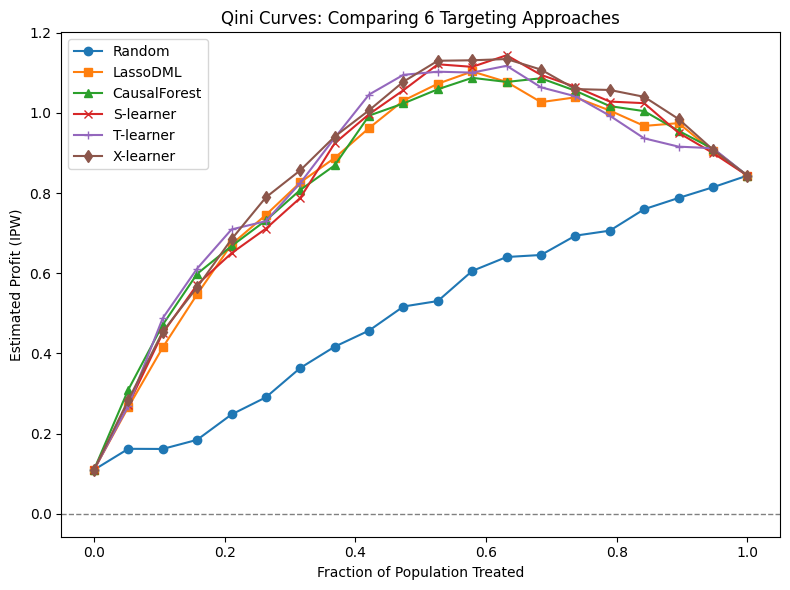


Profit at 50% Treated Fraction (IPW):
Method          Profit
------------  --------
Random           0.531
LassoDML         1.073
CausalForest     1.059
S-learner        1.121
T-learner        1.103
X-learner        1.130


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# econml
from econml.grf import CausalForest
from econml.dml import SparseLinearDML
from sklearn.linear_model import LassoCV

# For pretty printing
from tabulate import tabulate

##############################################################################
# 1) High-dimensional, Non-linear DGP
##############################################################################
def generate_data_complex(n=2000, n_features=10, seed=42):
    """
    DGP:
      X ~ N(0,1) in R^{n_features}
      W ~ Bernoulli(0.5)
      Y = baseline + TE*W + noise
    Where TE is a non-linear function of the first 3 features.
    """
    np.random.seed(seed)
    X = np.random.normal(0, 1, size=(n, n_features))
    W = np.random.binomial(1, 0.5, size=(n,))
    
    # Nonlinear TE
    TE = np.maximum(X[:, 0], 0) + 2.0 * np.sin(X[:, 1]) + 0.5 * (X[:, 2] ** 2)

    # Baseline linear part
    baseline = 0.3 * X[:, 3] - 0.7 * X[:, 4]
    
    # Noise
    eps = np.random.normal(0, 1.0, size=n)
    
    Y0 = baseline + eps
    Y1 = baseline + TE + eps
    Y  = np.where(W == 1, Y1, Y0)
    
    return X, W, Y, TE

##############################################################################
# 2) Custom S-, T-, X-learners
##############################################################################
class SLearner:
    def __init__(self, base_model=RandomForestRegressor()):
        self.base_model = base_model
    
    def fit(self, X, T, y):
        # X_plus_T: augment T as a feature
        X_plus_T = np.column_stack((X, T))
        self.base_model.fit(X_plus_T, y)
    
    def predict(self, X):
        # For effect: predict Y(1) - Y(0)
        n = X.shape[0]
        X1 = np.column_stack((X, np.ones(n)))
        X0 = np.column_stack((X, np.zeros(n)))
        return self.base_model.predict(X1) - self.base_model.predict(X0)

class TLearner:
    def __init__(self, base_model=RandomForestRegressor()):
        self.model_treated = base_model
        self.model_control = base_model.__class__()  # same model type
    
    def fit(self, X, T, y):
        self.model_treated.fit(X[T==1], y[T==1])
        self.model_control.fit(X[T==0], y[T==0])
    
    def predict(self, X):
        return self.model_treated.predict(X) - self.model_control.predict(X)

class XLearner:
    def __init__(self, base_model=RandomForestRegressor()):
        self.model_treated = base_model
        self.model_control = base_model.__class__()
        self.model_effect_treated = base_model.__class__()
        self.model_effect_control = base_model.__class__()
    
    def fit(self, X, T, y):
        # Stage 1
        self.model_treated.fit(X[T==1], y[T==1])
        self.model_control.fit(X[T==0], y[T==0])
        
        # Imputed effect for treated
        imputed_effect_treated = y[T==1] - self.model_control.predict(X[T==1])
        # Imputed effect for control
        imputed_effect_control = self.model_treated.predict(X[T==0]) - y[T==0]
        
        # Stage 2
        self.model_effect_treated.fit(X[T==1], imputed_effect_treated)
        self.model_effect_control.fit(X[T==0], imputed_effect_control)
    
    def predict(self, X):
        tau_treated = self.model_effect_treated.predict(X)
        tau_control = self.model_effect_control.predict(X)
        return 0.5 * (tau_treated + tau_control)

##############################################################################
# 3) Qini Curves via partial treatment + IPW
##############################################################################
def ipw_profit(Y0, Y1, W, policy, e_prop=0.5, m=1.0, c=0.0):
    """
    IPW formula for profit:
      (1/N) * sum over i of [
        (W_i*policy_i / e_prop)*(m*Y1_i - c) + ((1-W_i)*(1-policy_i)/(1-e_prop))*(m*Y0_i)
      ]
    """
    policy = policy.astype(int)
    numer = (
        (W * policy / e_prop) * (m * Y1 - c) +
        ((1 - W) * (1 - policy) / (1 - e_prop)) * (m * Y0)
    )
    return np.mean(numer)

def build_qini_curve(Y0, Y1, W, scores, e_prop=0.5, m=1.0, c=0.0,
                     num_points=20, random_policy=False):
    """
    Qini curve: for fractions in [0,1], treat that fraction of individuals
    either (a) at random or (b) top fraction by predicted effect 'scores'.
    Evaluate via IPW.
    """
    n = len(Y0)
    fractions = np.linspace(0, 1, num_points)
    profit_values = []
    
    if random_policy:
        rng = np.random.default_rng(999)
        shuffle_idx = rng.permutation(n)
        for frac in fractions:
            cutoff = int(frac * n)
            policy_arr = np.zeros(n, dtype=int)
            policy_arr[shuffle_idx[:cutoff]] = 1
            val = ipw_profit(Y0, Y1, W, policy_arr, e_prop=e_prop, m=m, c=c)
            profit_values.append(val)
    else:
        idx_sorted = np.argsort(-scores)  # descending
        for frac in fractions:
            cutoff = int(frac * n)
            policy_arr = np.zeros(n, dtype=int)
            policy_arr[idx_sorted[:cutoff]] = 1
            val = ipw_profit(Y0, Y1, W, policy_arr, e_prop=e_prop, m=m, c=c)
            profit_values.append(val)
    
    return fractions, profit_values

##############################################################################
# 4) Main script
##############################################################################
def main():
    # A. Generate data
    X, W, Y, TE_true = generate_data_complex(n=2000, n_features=10, seed=123)
    
    # Approximate Y0, Y1 for IPW
    #   Y0 = Y - W*TE_true
    #   Y1 = Y + (1-W)*TE_true
    Y0_approx = Y - W*TE_true
    Y1_approx = Y + (1 - W)*TE_true
    
    # Train-test split
    (X_train, X_test,
     W_train, W_test,
     Y_train, Y_test,
     Y0_train, Y0_test,
     Y1_train, Y1_test) = train_test_split(
        X, W, Y, Y0_approx, Y1_approx,
        test_size=0.3, random_state=42
    )
    
    # B. Fit multiple approaches
    # 1) Random will be handled in Qini code, no training needed
    
    # 2) Lasso-based (SparseLinearDML)
    dml = SparseLinearDML(model_y=LassoCV(), model_t=LassoCV(), random_state=42)
    dml.fit(Y=Y_train, T=W_train, X=X_train)
    te_lasso = dml.effect(X_test)
    
    # Causal Forest
    cf = CausalForest(
        n_estimators=100,
        min_samples_leaf=10,
        max_depth=None,
        random_state=42
    )
    # Ensure shapes are correct
    Y_train = np.ravel(Y_train)  # Ensures Y_train is 1D
    W_train = np.ravel(W_train)  # Ensures W_train is 1D

    # Fit the Causal Forest
    cf.fit(X_train, W_train, Y_train)
    te_cf = cf.predict(X_test)
    
    # 4) S-learner
    s_learner = SLearner(RandomForestRegressor(n_estimators=200, random_state=42))
    s_learner.fit(X_train, W_train, Y_train)
    te_s = s_learner.predict(X_test)
    
    # 5) T-learner
    t_learner = TLearner(RandomForestRegressor(n_estimators=200, random_state=42))
    t_learner.fit(X_train, W_train, Y_train)
    te_t = t_learner.predict(X_test)
    
    # 6) X-learner
    x_learner = XLearner(RandomForestRegressor(n_estimators=200, random_state=42))
    x_learner.fit(X_train, W_train, Y_train)
    te_x = x_learner.predict(X_test)
    
    # C. Build Qini curves
    # e_prop=0.5, m=1, c=1 => profit(treated)=Y1-1, not treated=Y0
    fr_random, q_random = build_qini_curve(Y0_test, Y1_test, W_test,
                                           scores=None, random_policy=True)
    fr_lasso, q_lasso    = build_qini_curve(Y0_test, Y1_test, W_test,
                                           scores=te_lasso.ravel(), random_policy=False)
    fr_cf, q_cf          = build_qini_curve(Y0_test, Y1_test, W_test,
                                           scores=te_cf.ravel(), random_policy=False)
    fr_s, q_s            = build_qini_curve(Y0_test, Y1_test, W_test,
                                           scores=te_s, random_policy=False)
    fr_t, q_t            = build_qini_curve(Y0_test, Y1_test, W_test,
                                           scores=te_t, random_policy=False)
    fr_x, q_x            = build_qini_curve(Y0_test, Y1_test, W_test,
                                           scores=te_x, random_policy=False)
    
    # D. Plot Qini curves
    plt.figure(figsize=(8,6))
    plt.plot(fr_random, q_random, label="Random", marker='o')
    plt.plot(fr_lasso,  q_lasso,  label="LassoDML", marker='s')
    plt.plot(fr_cf,     q_cf,     label="CausalForest", marker='^')
    plt.plot(fr_s,      q_s,      label="S-learner", marker='x')
    plt.plot(fr_t,      q_t,      label="T-learner", marker='+')
    plt.plot(fr_x,      q_x,      label="X-learner", marker='d')
    
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    plt.xlabel("Fraction of Population Treated")
    plt.ylabel("Estimated Profit (IPW)")
    plt.title("Qini Curves: Comparing 6 Targeting Approaches")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # E. Print summary at 50% fraction
    idx_50pct = np.argmin(np.abs(fr_random - 0.5))
    summary = [
        ["Random",       q_random[idx_50pct]],
        ["LassoDML",     q_lasso[idx_50pct]],
        ["CausalForest", q_cf[idx_50pct]],
        ["S-learner",    q_s[idx_50pct]],
        ["T-learner",    q_t[idx_50pct]],
        ["X-learner",    q_x[idx_50pct]]
    ]
    print("\nProfit at 50% Treated Fraction (IPW):")
    print(tabulate(summary, headers=["Method","Profit"], floatfmt=".3f"))

if __name__ == "__main__":
    main()


In [6]:
pip install econml

In [8]:
##############################################################################
# Finally, run main()
##############################################################################
if __name__ == "__main__":
    main()


ValueError: Expected 2D array, got 1D array instead:
array=[ 0.80883236  0.11546353  0.41529392 ... -0.76500508  0.33115466
  2.57480264].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.